# Transferencia de aprendizaje

Una red neuronal convolucional (CNN) para la clasificación de imágenes se compone de múltiples capas que extraen características, como bordes, esquinas, etc.; y luego use una capa final completamente conectada para clasificar objetos según estas características. Puedes visualizar esto así:

<table>
    <tr><td rowspan=2 style='border: 1px solid black;'>&#x21d2;</td><td style='border: 1px solid black;'>Capa de Convolucion</td><td style='border: 1px solid black;'>Capa de Agrupacion</td><td style='border: 1px solid black;'>Capa de Convolucion</td><td style='border: 1px solid black;'>Capa de Agrupacion</td><td style='border: 1px solid black;'>Capa completamente conectada</td><td rowspan=2 style='border: 1px solid black;'>&#x21d2;</td></tr>
    <tr><td colspan=4 style='border: 1px solid black; text-align:center;'>Extraccion de Caracteristicas</td><td style='border: 1px solid black; text-align:center;'>Clasificacion</td></tr>
</table>

*Transfer Learning* es una técnica en la que puede tomar un modelo entrenado existente y reutilizar sus capas de extracción de características, reemplazando su capa de clasificación final con una capa totalmente conectada entrenada en sus propias imágenes personalizadas. Con esta técnica, su modelo se beneficia del entrenamiento de extracción de características que se realizó en el modelo base (que puede haberse basado en un conjunto de datos de entrenamiento más grande al que tiene acceso) para construir un modelo de clasificación para su propio conjunto específico de clases de objetos.

¿Cómo ayuda esto? Bueno, piénsalo de esta manera. Suponga que toma a un jugador de tenis profesional y a un principiante absoluto y trata de enseñarles a ambos a jugar raquetball. Es razonable suponer que el jugador de tenis profesional será más fácil de entrenar, porque muchas de las habilidades subyacentes involucradas en el raquetball ya están aprendidas. De manera similar, un modelo de CNN preentrenado puede ser más fácil de entrenar para clasificar un conjunto específico de objetos porque ya aprendió cómo identificar las características de los objetos comunes, como los bordes y las esquinas. Fundamentalmente, un modelo preentrenado puede ser una excelente manera de producir un clasificador efectivo incluso cuando tiene datos limitados con los que entrenarlo.

En este cuaderno, veremos cómo implementar el aprendizaje de transferencia para un modelo de clasificación mediante PyTorch.

## Instalar e importar bibliotecas

Primero, instalemos e importemos las bibliotecas de PyTorch que vamos a usar.



In [2]:
# Importamos librerias de Pytorch
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

# Otras librerias que usaremos
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

print("Librerias importadas - Listo para usar PyTorch", torch.__version__)

Librerias importadas - Listo para usar PyTorch 1.11.0+cpu


## Preparar el modelo base

Para usar el aprendizaje por transferencia, necesitamos un modelo base a partir del cual podamos usar las capas de extracción de características entrenadas. El modelo ***resnet*** es un clasificador de imágenes basado en CNN que se ha entrenado previamente con un enorme conjunto de datos que contiene una gran cantidad de imágenes de 1000 clases de objetos, así que descárguemoslo y echemos un vistazo a sus capas.

In [3]:
# Cargue el modelo (descargar si aún no está presente)
model = torchvision.models.resnet34(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\personal/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Preparar los datos de la imagen

El modelo preentrenado tiene muchas capas, comenzando con una capa convolucional que inicia el proceso de extracción de características a partir de datos de imagen y terminando con una capa lineal totalmente conectada que asigna las características extraídas a 1000 etiquetas de clase.

Para que la extracción de características funcione con nuestras propias imágenes, debemos asegurarnos de que los datos de imagen que usamos para entrenar nuestra capa de predicción tengan la misma cantidad de características (valores de píxeles) que las imágenes que se usaron originalmente para entrenar las capas de extracción de características. El modelo no proporciona explícitamente este tamaño, pero la primera capa convolucional se aplica mediante un núcleo de 7x7 con un paso de 2x2 y da como resultado 64 valores de características, por lo que el tamaño original debe ser 64 x (7 &div; 2), que es 224.

PyTorch incluye funciones para cargar y transformar datos. Los usaremos para crear un cargador iterativo para datos de entrenamiento y un segundo cargador iterativo para datos de prueba (que usaremos para validar el modelo entrenado). Los cargadores transformarán los datos de la imagen para que coincidan con el formato utilizado para entrenar el modelo CNN resnet original, convertirán los datos de la imagen en *tensores* (que son la estructura de datos central utilizada en PyTorch) y los normalizarán.

Ejecute la siguiente celda para definir los cargadores de datos y enumere las clases para nuestras imágenes.

In [4]:
# Funcion de ingesta de datos de entrenamiento y testeo usando cargadores
def load_dataset(data_path):
    
    # Cambie el tamaño a 256 x 256, luego recorte al centro a 224x224 (para que coincida con el tamaño de la imagen resnet)
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Carga todas las imágenes, transformándolas
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    # Dividir en conjuntos de datos de entrenamiento (70 %) y prueba (30 %)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # definir un cargador para los datos de entrenamiento que podemos iterar en lotes de 30 imágenes
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=30,
        num_workers=0,
        shuffle=False
    )
    
    # definir un cargador para los datos de prueba que podemos recorrer en lotes de 30 imágenes
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=30,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader


# Ahora cargue las imágenes de la carpeta 
import os  
data_path = 'data/shapes/'

# Obtenga los cargadores de datos iterativos para datos de prueba y entrenamiento
train_loader, test_loader = load_dataset(data_path)

# Obtener los nombres de las clases
classes = os.listdir(data_path)
classes.sort()
print('class names:', classes)

class names: ['circle', 'square', 'triangle']


## Crear una capa de predicción

Descargamos el modelo *resnet* completo, incluida su capa lineal **fc** final. Esta capa lineal completamente conectada toma 512 entradas (las características extraídas) y produce 1000 salidas (predicciones de clase basadas en las clases de imágenes de entrenamiento originales). Necesitamos reemplazar esta capa con una que tome la misma cantidad de entradas (para que podamos usar la misma cantidad de características extraídas), pero que produzca una predicción para cada una de nuestras clases de imágenes.

También necesitamos congelar las capas de extracción de características para retener los pesos entrenados. Luego, cuando entrenamos el modelo usando nuestras imágenes, solo la capa de predicción final aprenderá nuevos valores de ponderación y sesgo; las ponderaciones previamente entrenadas ya aprendidas para la extracción de características seguirán siendo las mismas.

In [5]:
# Establecer las capas de extracción de características existentes en solo lectura
for param in model.parameters():
    param.requires_grad = False

# Reemplezar las capas de prediccion
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))

# Imprimimos el modelo 
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Entrenar al modelo

Con las capas de la CNN definidas, estamos listos para entrenarla usando nuestros datos de imagen. Los pesos utilizados en las capas de extracción de características del modelo base de resnet no cambiarán con el entrenamiento, solo se entrenará la capa lineal final que asigna las características a nuestras clases de forma.

In [6]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
    
    
# Now use the train and test functions to train and test the model    

device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model = model.to(device)

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 3 epochs (in a real scenario, you'd likely use many more)
epochs = 3
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
Training set [0/840 (0%)] Loss: 1.225248
Training set [300/840 (36%)] Loss: 0.592051
Training set [600/840 (71%)] Loss: 0.479853
Training set: Average loss: 0.570875
Validation set: Average loss: 0.342032, Accuracy: 332/360 (92%)

Epoch: 2
Training set [0/840 (0%)] Loss: 0.281919
Training set [300/840 (36%)] Loss: 0.146559
Training set [600/840 (71%)] Loss: 0.172538
Training set: Average loss: 0.177797
Validation set: Average loss: 0.100043, Accuracy: 360/360 (100%)

Epoch: 3
Training set [0/840 (0%)] Loss: 0.117674
Training set [300/840 (36%)] Loss: 0.072602
Training set [600/840 (71%)] Loss: 0.105061
Training set: Average loss: 0.097504
Validation set: Average loss: 0.064687, Accuracy: 360/360 (100%)



## Ver el historial de pérdidas

Hicimos un seguimiento de la pérdida promedio de entrenamiento y validación para cada época. Podemos graficar esto para verificar que la pérdida se redujo durante el proceso de entrenamiento y para detectar *sobreajuste* (que se indica por una caída continua en la pérdida de entrenamiento después de que la pérdida de validación se niveló o comenzó a aumentar).

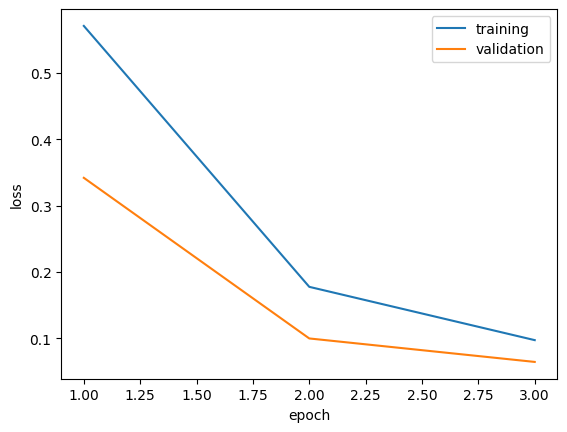

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## Evaluar el rendimiento del modelo

Podemos ver la precisión final en función de los datos de prueba, pero por lo general querremos explorar las métricas de rendimiento con un poco más de profundidad. Tracemos una matriz de confusión para ver qué tan bien el modelo predice cada clase.

Getting predictions from test set...


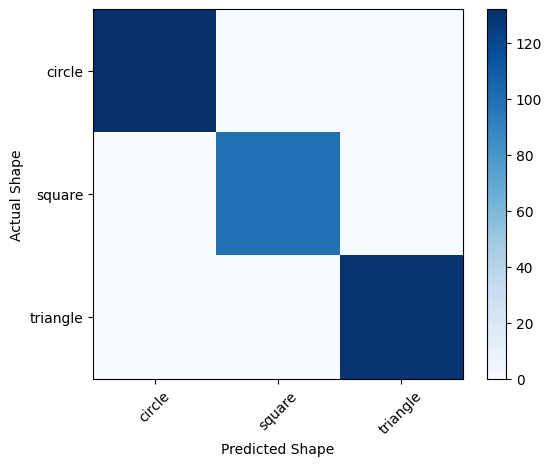

In [8]:
#Pytorch doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data and convert to numpy arrays for use with SciKit-Learn
print("Getting predictions from test set...")
truelabels = []
predictions = []
for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

## Usar el modelo entrenado

Ahora que hemos entrenado el modelo, podemos usarlo para predecir la clase de una imagen.

square


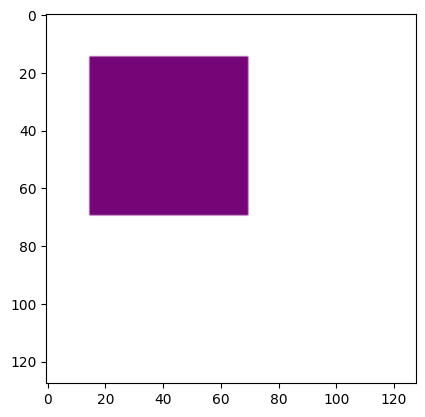

In [9]:
# Function to create a random image (of a square, circle, or triangle)
def create_image (size, shape):
    from random import randint
    import numpy as np
    from PIL import Image, ImageDraw
    
    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    if shape == 'circle':
        draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
    elif shape == 'triangle':
        draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
    else: # square
        draw.rectangle([(xy1,xy1), (xy2,xy2)], fill=col)
    del draw
    
    return img
    
# Function to predict the class of an image
def predict_image(classifier, image):
    import numpy
    
    # Set the classifer model to evaluation mode
    classifier.eval()
    
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all inputs as batches
    image_tensor = image_tensor.unsqueeze_(0)

    # Turn the input into a Variable
    input_features = Variable(image_tensor)

    # Predict the class of the image
    output = classifier(input_features)
    index = output.data.numpy().argmax()
    return index


# Now let's try it with a new image
from random import randint
from PIL import Image
import os, shutil

# Create a random test image
shape = classes[randint(0, len(classes)-1)]
img = create_image ((128,128), shape)

# Display the image
plt.imshow(img)


index = predict_image(model, img)
print(classes[index])